In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auction_verification = fetch_ucirepo(id=713) 
  
# data (as pandas dataframes) 
X = auction_verification.data.features 
y = auction_verification.data.targets 
  
# variable information 
print(auction_verification.variables) 

                  name     role         type demographic  \
0  process.b1.capacity  Feature      Integer        None   
1  process.b2.capacity  Feature      Integer        None   
2  process.b3.capacity  Feature      Integer        None   
3  process.b4.capacity  Feature      Integer        None   
4       property.price  Feature      Integer        None   
5     property.product  Feature      Integer        None   
6      property.winner  Feature      Integer        None   
7  verification.result   Target  Categorical        None   
8    verification.time   Target   Continuous        None   

                                         description units missing_values  
0  Capacity (max number of products to win) of Bi...  None             no  
1  Capacity (max number of products to win) of Bi...  None             no  
2  Capacity (max number of products to win) of Bi...  None             no  
3  Capacity (max number of products to win) of Bi...  None             no  
4                  

In [4]:
for key, value in auction_verification.metadata.items():
    if isinstance(value, dict):
        for k, v in value.items():
            print(f'{k}: {v}')
    else:
        print(f'{key}: {value}')

uci_id: 713
name: Auction Verification
repository_url: https://archive.ics.uci.edu/dataset/713/auction+verification
data_url: https://archive.ics.uci.edu/static/public/713/data.csv
abstract: We modeled a simultaneous multi-round auction with BPMN models, transformed the latter to Petri nets, and used a model checker to verify whether certain outcomes of the auction are possible or not.
area: Computer Science
tasks: ['Classification', 'Regression']
characteristics: ['Tabular']
num_instances: 2043
num_features: 7
feature_types: []
demographics: []
target_col: ['verification.result', 'verification.time']
index_col: None
has_missing_values: no
missing_values_symbol: None
year_of_dataset_creation: 2022
last_updated: Sun Apr 24 2022
dataset_doi: 10.24432/C52K6N
creators: ['Elaheh Ordoni', 'Jakob Bach', 'Ann-Katrin Fleck', 'Jakob Bach']
title: Analyzing and Predicting Verification of Data-Aware Process Models – a Case Study with Spectrum Auctions
authors: Elaheh Ordoni, Jakob Bach, Ann-Katrin

### EDA

In [6]:
X.shape

(2043, 7)

In [7]:
X.describe()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000
mean,1.000000,2.093979,1.883994,0.587861,71.473324,3.252080,0.455213
std,0.816696,0.811269,0.320310,0.492340,8.048740,1.804225,1.062828
min,0.000000,0.000000,1.000000,0.000000,59.000000,1.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,65.000000,2.000000,0.000000
50%,1.000000,2.000000,2.000000,1.000000,70.000000,3.000000,0.000000
75%,2.000000,3.000000,2.000000,1.000000,78.000000,5.000000,0.000000
max,2.000000,3.000000,2.000000,1.000000,90.000000,6.000000,4.000000


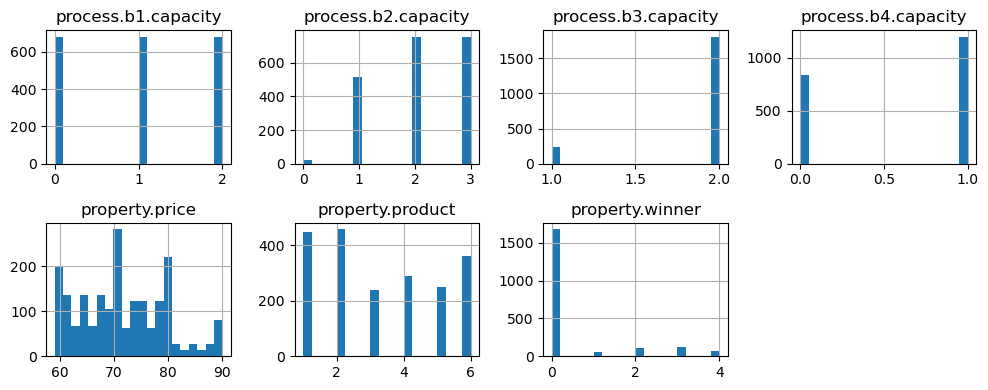

In [8]:
X.hist(figsize=(10, 4), layout=(2,4), bins=20)
plt.tight_layout()

In [9]:
y.shape

(2043, 2)

In [10]:
y.columns

Index(['verification.result', 'verification.time'], dtype='object')

<Axes: xlabel='verification.result', ylabel='count'>

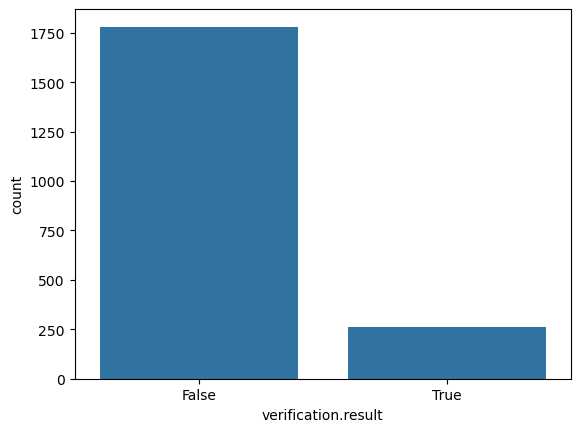

In [11]:
sns.countplot(data=y, x='verification.result')

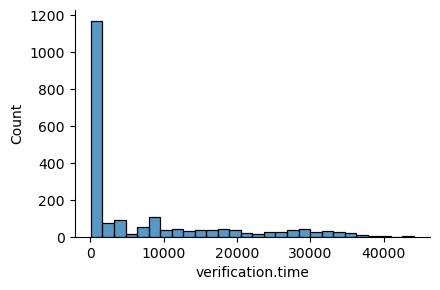

In [12]:
sns.displot(y['verification.time'], height=3, aspect=1.5)

### Basic model, for comparison with ensembles

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
# scaling, filling gaps, validation
target = y['verification.result']

dt = DecisionTreeClassifier(random_state=42)     

cv_results_dt = cross_validate(dt,
                            X, target,
                            cv=5,
                            scoring='roc_auc',
                            return_train_score=False
                           )

mean_test_score = cv_results_dt['test_score'].mean()

print(f"Decision trees ROC AUC: {mean_test_score:.3f}")
print("Fold Scores:", cv_results_dt['test_score'])

pipeline = make_pipeline(MinMaxScaler(feature_range=(0, 1)),
                         LogisticRegression() 
                        )

cv_results_lr = cross_validate(pipeline,
                            X, target,
                            cv=5,
                            scoring='roc_auc',
                            return_train_score=False
                           )

mean_test_score = cv_results_lr['test_score'].mean()

print(f"Logistic regression ROC AUC: {mean_test_score:.3f}")
print("Fold Scores:", cv_results_lr['test_score'])

Decision trees ROC AUC: 0.848
Fold Scores: [0.50972312 0.76825843 0.96226415 1.         1.        ]
Logistic regression ROC AUC: 0.748
Fold Scores: [0.62642749 0.63668645 0.80559678 0.83815903 0.83383751]


### Random forest classifier

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

rfc = RandomForestClassifier(random_state=42)

params = {'n_estimators': [200, 350,  500],
          'min_samples_split': [5, 10],
          'min_samples_leaf': [5, 7],
          'max_depth' : [3, 4, 5],
          'criterion' :['gini', 'entropy']
         }

grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, 
                           scoring = "roc_auc")

grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=350, random_state=42)
0.963264813181806


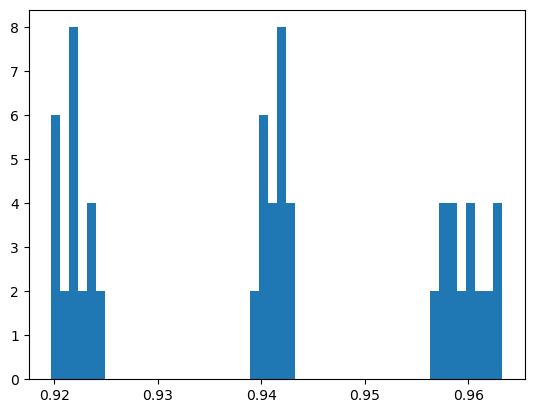

In [18]:
results = grid_search.cv_results_
scores = results['mean_test_score']
_ = plt.hist(scores, bins=50)

In [19]:
#Feature importance
for f in range(len(X.columns)):
    print(X.columns[f], ' - ', grid_search.best_estimator_.feature_importances_[f].round(2))

process.b1.capacity  -  0.08
process.b2.capacity  -  0.05
process.b3.capacity  -  0.02
process.b4.capacity  -  0.01
property.price  -  0.41
property.product  -  0.08
property.winner  -  0.35


In [20]:
#random foredt + StratifiedKFold
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
mean_auc_rf = []

for train_index , test_index in kf.split(X, target):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = target[train_index] , target[test_index]

    rf = RandomForestClassifier(criterion='entropy', 
                                max_depth=5, 
                                min_samples_leaf=5,
                                min_samples_split=5, 
                                n_estimators=350, 
                                random_state=42
                               )
    rf.fit(X_train, y_train)

    probs = rf.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, probs[:,1])
    mean_auc_rf.append(roc_auc)  

print(f"RandomForest mean ROC AUC: {np.mean(mean_auc_rf)}")
print(mean_auc_rf)

RandomForest mean ROC AUC: 0.9689650097249644
[0.9534583063994829, 0.9668751324994701, 0.9741891032435869, 0.9801750216076058, 0.9701274848746758]


### Boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
#gradient boosting + cross_validate
gbc = GradientBoostingClassifier()
    
cv_results_gbc = cross_validate(gbc,
                                X, target,
                                cv=5,
                                scoring='roc_auc',
                                return_train_score=False
                               )

mean_test_score = cv_results_gbc['test_score'].mean()

print(f"gbc ROC AUC: {mean_test_score:.3f}")
print("Fold Scores:", cv_results_gbc['test_score'])

gbc ROC AUC: 0.947
Fold Scores: [0.88555807 0.85896756 0.99745601 0.99751513 0.99783924]


In [24]:
from lightgbm import LGBMClassifier

In [25]:
#lightgbm and gradient boosting + StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True)
mean_auc_gbc = []
mean_auc_lgbm = []


for train_index , test_index in kf.split(X, target):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = target[train_index] , target[test_index]

    gbc = GradientBoostingClassifier()
    gbc.fit(X_train, y_train)

    probs = gbc.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, probs[:,1])
    mean_auc_gbc.append(roc_auc)    

    lgbm = LGBMClassifier(verbosity=-1, random_state=42)
    lgbm.fit(X=X_train,
              y=y_train,
              eval_set=(X_test, y_test),
              eval_metric='logloss'
             )

    importance = lgbm.feature_importances_
   
    probs = lgbm.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, probs[:,1])
    mean_auc_lgbm.append(roc_auc)
    
print(f"GBC mean ROC AUC: {np.mean(mean_auc_gbc)}")
print(mean_auc_gbc)
print(f"LGBM mean ROC AUC: {np.mean(mean_auc_lgbm)}")
print(mean_auc_lgbm)


GBC mean ROC AUC: 0.9977492091486063
[0.9987879767291532, 0.9983835064659742, 0.9943025227899088, 0.9982443820224719, 0.9990276577355229]
LGBM mean ROC AUC: 0.9999783923941227
[1.0, 1.0, 1.0, 0.9998919619706137, 1.0]


LGBM показав найвищий ROC AUC серед всіх моделей. Близький до 1.
Помітив різницю у score GBC у випадку використання cross_validate в порівнні з stratifiedkfold. Як виявилося це пов'язано із вказання параметра shuffle=True у випадку stratifiedkfold, в той час як в cross_validate у нього значення False.

In [27]:
feature_importance = pd.DataFrame({
    'feature': lgbm.feature_name_,
    'importance': lgbm.feature_importances_
})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print(feature_importance)

               feature  importance
4       property.price         911
5     property.product         776
6      property.winner         702
0  process.b1.capacity         287
1  process.b2.capacity         259
3  process.b4.capacity          28
2  process.b3.capacity          23


### Stacking

In [29]:
from sklearn.ensemble import StackingClassifier

In [30]:
#stacking of 3 models
dt = DecisionTreeClassifier(max_depth=4)
rfc = RandomForestClassifier(max_depth=4, 
                             min_samples_leaf=5, 
                             min_samples_split=5,
                             n_estimators=500, 
                             random_state=42
                            )
gbc = GradientBoostingClassifier()

estimators_list = [('desicion tree', dt),
                   ('random forest', rfc),
                   ('gradient boosting', gbc)
                  ]
                    

sc = StackingClassifier(estimators=estimators_list)

cv_results_sc = cross_validate(sc,
                               X, target,
                               cv=5,
                               scoring='roc_auc',
                               return_train_score=False
                               )

mean_test_score = cv_results_sc['test_score'].mean()

print(f"stacking ROC AUC: {mean_test_score:.3f}")
print("Fold Scores:", cv_results_sc['test_score'])

stacking ROC AUC: 0.939
Fold Scores: [0.88014437 0.82319271 0.99602502 0.99740709 0.99827139]
